# Pulse Optimization

Optimal control theory is an extremely versatile set of techniques that can be applied in many situations. Although optimal control entails many fields, the general idea is to use a feedback loop between an agent and a target system. Optimal control is applied to several quantum technologies, including the pulse shaping of gate designs in quantum circuits to minimize noise. Generally, the pulse shaping is a passive technique, whereby a classically computation takes place beforehand to find an optimal pulse without active feedback from a quantum system }. Gradient Ascent Pulse Engineering (GRAPE) is a powerful technique that uses gradient ascent and a nonlinear optimization solver, such as Broyden–Fletcher–Goldfarb–Shanno (BFGS) algorithm, to solve for a pulse shape to achieve a desired operation. Although powerful, the technique requires the simulation of quantum dynamics on a classical computer, which scales exponentially with quantum system size.

Quantum optimal control deals with fitting pulses $a_i(t)$, or $a_{i,n}$ for a discrete solution, for a Hamiltonian $H$ oftern written written in terms of a drift $H_d$ and several control Hamiltonians $H_{i}$ that are modulated by pulses. The dynamics is governed by

$$
    \pdv{}{t}\ket{\psi} = \left(H_d + \sum_i a_i(t)H_{i} \right)\ket{\psi}.
$$

Many factors play into the quality of pulses, including time, amplitude, shape, as well as hardware-specific limitations in sampling rate.


## Python Example

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class Transmon(object):
    '''
    Class to build Cooper-Pair Box (Transmons) Hamiltonians from frequencies and approximate
    the control matrices of the box coupled to a cavity.
    A derivation and review is outlined here: https://arxiv.org/abs/cond-mat/0703002

    Parameters
    ----------
    transitions : list
        A list of transitions frequencies. E.g.: [w_01, w_12, w_23]

    n_cut : int
        The size of the truncated basis for Transmon Hamiltonian

    method : str
        What method to use to fit the frequencies to Transmon Hamiltonian
            - basis : use lowest two levels of a Transmon
            - fit : solve an optimization to fit the transitions using gradients

    '''
    def __init__(self, transitions, n_cut=40, method='fit'):
        from numpy import asarray, array, linspace, arange, diag, zeros, ones, triu, tril, cumsum, pi, eye, stack, einsum, diff
        from numpy.linalg import eigh
        from scipy.optimize import minimize

        transitions = asarray(transitions)

        if transitions.size < 2:
            raise ValueError('To recover E_c and E_j you need at least two transition energies')

        levels = transitions.size + 1


        # Layout of Hamiltonian in truncated basis
        self.n_cut = n_cut
        self._n = diag(arange(-n_cut, n_cut + 1))
        self._hc_n2 = 4 * self._n @ self._n
        self._hc_n1 = -2 * 4 * self._n
        self._hc_n0 = 4 * eye(len(self._n))
        self._hj =  -.5 * (diag(ones(2 * n_cut), 1) + diag(ones(2 * n_cut), -1))

        # Approximate the EC and EJ from first two transitions
        self._EC = (transitions[0] - transitions[1])
        self._EJ = (transitions[1] + self._EC)**2/(8*self._EC)
        self._ng = 0

        if method == 'basic':
            # Just use the approximated values
            pass
        elif method == 'fit':
            # Start with approximated values and then improve them via a fit to transitions
            x0 = array([self._EC, self._EJ, self._ng])

            def get_grads(ec, ej, ng=0, grad_includes_ng=False):
                dh_dec = (self._hc_n2 + ng * self._hc_n1 + ng**2 * self._hc_n0)
                dh_dej = self._hj
                if grad_includes_ng:
                    dh_dng = ec * (self._hc_n1 + 2 * ng * self._hc_n0)
                    grads = stack([dh_dec, dh_dej, dh_dng], axis=0)
                else:
                    grads = stack([dh_dec, dh_dej], axis=0)
                return grads
    
            def get_transitions(ec, ej, ng=0,  grad_includes_ng=False):
                h = ec * (self._hc_n2 + ng * self._hc_n1 + ng**2 * self._hc_n0) + ej * self._hj
                grads = get_grads(ec, ej, ng=ng, grad_includes_ng=grad_includes_ng)
                vals, vecs = eigh(h)
                d_vals = einsum('xij,ia,ja->xa', grads, vecs.conj(), vecs)
                return diff(vals), diff(d_vals, axis=-1)

            def loss_with_grad(ec_ej_ng):
                t, dt = get_transitions(*ec_ej_ng, grad_includes_ng=len(ec_ej_ng)==3)
                t = t[:transitions.size]
                dt = dt[:, :transitions.size]
                r = t - transitions
                dr = dt
                loss = r @  r
                grad_loss = 2 * dr @ r
                return loss, grad_loss

            result = minimize(loss_with_grad, x0=x0, jac=True)
            self._EC, self._EJ, self._ng = result.x

        else:
            raise ValueError('No option for method: ' + method)

        # Construct the Transmon Hamiltonian with fitted EC/EJ/ng
        self._H_T = self._EC * (self._hc_n2 + self._ng * self._hc_n1 + self._ng**2 * self._hc_n0) + self._EJ * self._hj

        # Solve for wavefunctions and energies
        eigs, evec = eigh(self._H_T)

        # Charge operator
        N_operator = diag(arange(-n_cut, n_cut + 1))

        # Write the Hamiltonian in charge basis
        def charge(i, j):
            return evec[:, i] @ N_operator @ evec[:, j]
        charge_hat = array([charge(i,j) for i in range(0, levels) for j in range(0,levels)]).reshape(levels,levels)
        charge_hat /= charge_hat[0,1]

        # Get the creation and destruction operators
        c_destroy = triu(charge_hat)
        c_create = tril(charge_hat)

        # Write the Hamiltonians in rotating wave
        tilde_c_dag = diag(diag(charge_hat, -1), -1)
        tilde_c = diag(diag(charge_hat, 1), 1) 

        h_c = (tilde_c + tilde_c_dag, 1j * (tilde_c - tilde_c_dag))

        # Set the drive frequency to be the first transition frequency (rotating wave approximation)
        freq = [0, *transitions]
        wb = cumsum(freq) * 2 * pi

        ad_a = diag(arange(levels))
        h_d = eye(levels, dtype='complex128') * wb - ad_a * wb[1]

        self._h_d = h_d
        self._h_c = h_c
        self._levels = levels

    def drift(self):
        from numpy import array
        return array(self._h_d, copy=True, dtype='complex128')

    def control(self):
        from numpy import array
        return array(self._h_c, copy=True, dtype='complex128')

<!-- ```{code-cell} ipython3
freq = [4.80637   , 4.58210259, 4.33777661]

transmon = Transmon(freq)
``` -->

<!-- ```{code-cell} ipython3
import qutip as qp
from qutip.control.grape import cy_grape_unitary

H = np.array([[1, 1], [1, -1]]) / np.sqrt(2)

U = np.eye(3, dtype='complex128')
U[:2, :2] = H
U = qp.Qobj(U)

H_ops = [qp.Qobj(h[:3, :3]) for h in transmon.control()]

H_d = transmon.drift()[:3, :3]

print(U)
``` -->

<!-- ```{code-cell} ipython3


T = 1
times = np.linspace(0, T, 100)



theta, phi = np.random.rand(2)

U = qp.rz(phi) * qp.rx(theta); U

R = 150
H_ops = [qp.sigmax(), qp.sigmay(), qp.sigmaz()]


result = cy_grape_unitary(U, H0, H_ops, R, times, eps=2*np.pi/T, phase_sensitive=False)
``` -->

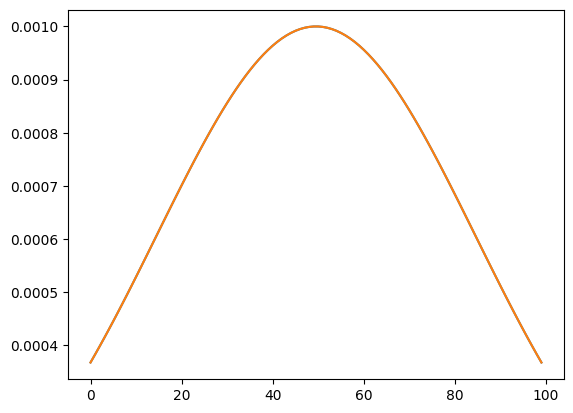

In [2]:
import qutip as qp

T = 1
times = np.linspace(0, T, 100)


H = np.array([[1, 1], [1, -1]]) / np.sqrt(2)

H0 = 0 * np.pi * qp.sigmaz()


R = 150
H_ops = [qp.sigmax(), qp.sigmay()]

from qutip.control import cy_grape_unitary
from qutip.ui.progressbar import TextProgressBar

x = np.linspace(-1, +1, times.size)
initial_amplitudes = 1e-3 * np.stack([np.exp(-x**2), np.exp(-x**2)], -1)

qutip_pulse = cy_grape_unitary(qp.Qobj(H), H0, H_ops, R, times,u_start=initial_amplitudes.T, eps=2*np.pi/T, phase_sensitive=False)

plt.plot(initial_amplitudes)
plt.show()

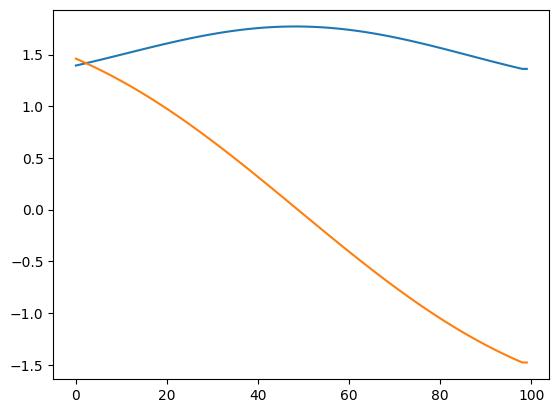

In [3]:
qutip_pulse.u.shape
plt.plot(qutip_pulse.u[-1, 0,:])
plt.plot(qutip_pulse.u[-1, 1,:])
plt.show()

In [4]:
psi0 = qp.basis(2, 0)
c_ops = []
e_ops = [qp.sigmax(), qp.sigmay(), qp.sigmaz()]

result = qp.mesolve(qutip_pulse.H_t, psi0, times, c_ops, e_ops)

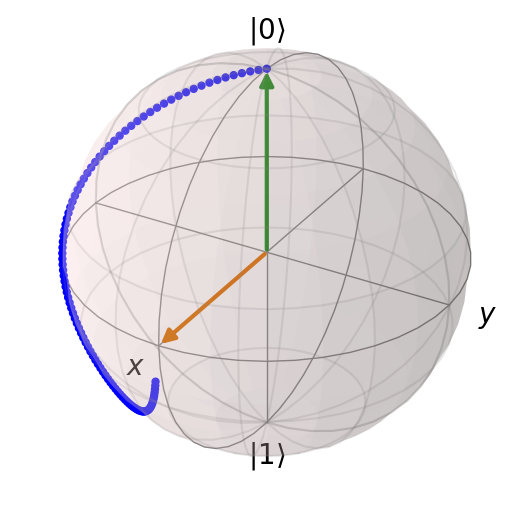

In [5]:
b = qp.Bloch()
b.add_points(result.expect)

b.add_states(psi0)
b.add_states(qp.Qobj(H) * psi0)
b.show()


## Holonomic Quantum Computing 

Holonomic quantum computing exploits the notion of _parallel transport_. Consider, for example, a vector that is transported around in a closed loop along a sphere -- as shown in figure~\ref{fig:parallel-transport}. It turns out that the vector itself will rotate by angle $\alpha$, dependent on the total _area_ covered by the closed loop. As long as the area remains the same, the actual _path_ does not matter. Holonomic quantum computing exploits this principle to produce gates that are robust to noise in the control _path_. Namely, it can produce a propogator $U$ that is factorized into two terms, $U = V(T) \otimes \Gamma$ where $V(T)$ is the dynamical part, and $\Gamma$ is a unitary transformation which is determined only by the geometry of the quantum system and is called geometric phase. We then recall that the geometric factor can be discussed in the case of Abelian U$(1)$ and non-Abelian U$(N)$ phase factors.

Consider a time-dependent Hamiltonian $H(t)$, with a solution to the corresponding Shrödinger equation $\ket{\psi(t)}$ in a time window $t \in [0, T]$. The solution of the Schrödinger equation

$$
i \dv{}{t} \ket{\psi(t)} = H(t) \ket{\psi(t)}
$$
defines a curve

$$
    C : t \in [0, T] \longrightarrow \ket{\psi(t)} \in \mathcal{H}.
$$

Taking a representative $\ket{\phi(t)}$ along the curve, it is related to the solution via a local phase transformation

$$
  \ket{\psi(t)} = e^{i\chi(t)} \ket{\phi(t)}
$$

We can rewrite the previous equation as:

$$
i \dv{}{t} \left [ e^{i\chi(t)} \ket{\phi(t)} \right ] = e^{i\chi(t)} H(t) \ket{\phi(t)},
$$ 
and 

$$
  -\dot\chi(t)e^{i\chi(t)}\ket{\phi(t)} + ie^{i\chi(t)}\ket{\dot\phi(t)} = e^{i \chi(t)}H(t)\ket{\phi(t)}.
$$

Multiplying $\bra{\psi(t)}$ on the left, we have

$$
  \dot\chi(t) = i\bra{\phi(t)}\ket{\dot\phi(t)} - \bra{\phi(t)}H(t)\ket{\phi(t)},
$$
which yields

$$
  \chi(T) - \chi(0) = \int_0^T i\bra{\phi(t)}\ket{\dot\phi(t)} - \int_0^T \bra{\phi(t)}H(t)\ket{\phi(t)}.
$$

The first term on on the right hand side is invariant under time parametrization $t \rightarrow t^\prime(t)$ and can be written as $\int i \bra{\phi}\ket{d\phi}$. The second term is invariant under phase transformations $\ket{\chi(t)} \rightarrow e^{i\alpha}\ket{\phi(t)}$, but not under time parametrization. This term is the instantaneous expectation value of the energy $E(t)$ computing along the solution. The yields a final equation:

$$
  \chi(T) - \chi(0) = - \int_{\phi(t)} A - \int_{\phi(t)} E(t)dt
$$

A special cases occurs when the evolution of the system is cyclic, i.e. $\ket{\phi(T)} = e^{i\alpha} \ket{\psi(0)}$. Selecting a representative closed curve $\ket{\phi(t)}$, with $\ket{\phi(t)} = e^{i \chi(t)}\ket{\phi(t)}$ and $\ket{\phi(T)} = \ket{\phi(0)} = \ket{\psi(0)}$ we have that

$$
  \alpha = - \oint_{\phi(t)} A - \oint_{\phi(t)} E(t) dt
$$

Note that for a closed curve, the integral $\oint A$ is invariant. The corresponding phase factor $e^{i \oint A}$ is called the holonomy.

Take a coherent superposition of the initial and final state

$$
    \ket{\psi(0)} + \ket{\psi(T)} = (1 + e^{i\alpha}) \ket{\psi(0)}
$$

we can in principle observe an interference pattern which is made by two contributions: the dynamical phase which is given by the instantaneous energy as $\oint E(t) dt$, and an additional phase shift which is the holonomy $e^{-\oint A}$. Since the additional factor $e^{-i\oint A}$ only depends on the loop, it is called the geometric phase. Since the cyclic dynamics appear as a special feature for the solution of the Schrodinger equation, it can only be determined _a posteriori_, and, in general, the time dependence of the Hamiltonian does not given any information about it, e.g. the Hamiltonian might not be cyclic, $H(T) \neq H(0)$.

However, finding holonomic gates in state space is abstract.  In an experimental setting, there is no direct handling of quantum states, rather the only information is the effective Hamiltonians that drive a system. It would be preferable to control a system and determine _a priori_ if the evolution of the system will be cyclic. One way this can be done is by working in the _adiabatic regime_, which places a requirement in the rate of change of a Hamiltonian. Alternatively, one can ignore the adiabatic constraint, but work with systems which have an effective Hamiltonian that provides some sort of known guarantee of cyclic evolution.

Consider a quantum system with a finite number of levels, $\mathcal{H} \cong \mathcal{C}^N$. The Hamiltonian can be written as

$$
  H = \sum_\alpha h_\alpha \lambda_\alpha
$$
where $h_\alpha$ is a real and the operators $\{\lambda_\alpha\}_{\alpha=1}^{N^2}$ are a basis in the linear space of Hermitian operators, such as the generalized Gell-Mann matrices, or the Pauli matrices for $N = 2$. From this point of view, a Hamiltonian is an element in a $N^2$-dimensional real vector space. Hence, a time dependent Hamiltonian,

$$
H(t) = \sum_\alpha h_\alpha(t) \lambda_\alpha
$$
defines a path in $\mathcal{R}^{N^2}$, and a cyclic Hamiltonian a closed loop. However, the emphasis here is that the quantum state must be cyclic in order to realize a holonomy, and not necessarily the Hamiltonian. In the adiabatic regime, we can say that a cyclic Hamiltonian will result in a cyclic state, but this is not always true.